In [1]:
%%capture
!pip install openai tiktoken wikipedia

In [34]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import tiktoken
import wikipedia

from bs4 import BeautifulSoup
from openai import OpenAI
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from textwrap import dedent
from tqdm.notebook import tqdm
from urllib.request import urlopen

In [3]:
pd.options.mode.chained_assignment = None

## OpenAI API call

In [4]:
client = OpenAI(
    api_key='OPENAI_API_KEY',
)

In [5]:
def get_gpt_response(prompt):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                'role': 'user',
                'content': prompt,
            }
        ],
        model='gpt-4o',
        temperature=0.2
    )
    return chat_completion.choices[0].message.content

## Counting Tokens

In [7]:
encoding = tiktoken.encoding_for_model('gpt-4o')

In [8]:
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    num_tokens = len(encoding.encode(string))
    return num_tokens

## Google Drive Paths

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs'

In [11]:
df_ground_truth = pd.read_csv('/content/drive/MyDrive/ground_truth_rag.csv')
df_ground_truth_number_of_cases = pd.read_csv('/content/drive/MyDrive/ground_truth_rag_number_of_cases.csv')

## Wikipedia Summaries

In [12]:
def get_query(term, language):
    soup = BeautifulSoup(urlopen('http://en.wikipedia.org/wiki/' + (term[:1].upper() + term[1:]).replace(' ', '_')), features='lxml')
    interwikihead = soup.find('li', class_=('interlanguage-link interwiki-' + language + ' mw-list-item'))

    try:
        if language == 'en':
            title = term[:1].upper() + term[1:]
        else:
            title = interwikihead.a.get('title').split(u' – ')[0]
        wikipedia.set_lang(language)
        page = wikipedia.page(title, auto_suggest=False)
        return page.summary
    except:
        return None

In [13]:
word_order_wiki = get_query('Word order', 'en')
negation_wiki = get_query('Affirmation and negation', 'en')
polar_questions_wiki = get_query('Yes-no question', 'en')
grammatical_case_wiki = dedent('''A grammatical case is a category of nouns and noun modifiers (determiners, adjectives, participles, and numerals) that corresponds to one or more potential grammatical functions for a nominal group in a wording.[1] In various languages, nominal groups consisting of a noun and its modifiers belong to one of a few such categories. For instance, in English, one says I see them and they see me: the nominative pronouns I/they represent the perceiver and the accusative pronouns me/them represent the phenomenon perceived. Here, nominative and accusative are cases, that is, categories of pronouns corresponding to the functions they have in representation.
English has largely lost its inflected case system but personal pronouns still have three cases, which are simplified forms of the nominative, accusative (including functions formerly handled by the dative) and genitive cases. They are used with personal pronouns: subjective case (I, you, he, she, it, we, they, who, whoever), objective case (me, you, him, her, it, us, them, whom, whomever) and possessive case (my, mine; your, yours; his; her, hers; its; our, ours; their, theirs; whose; whosever).[2][3] Forms such as I, he and we are used for the subject ("I kicked John"), and forms such as me, him and us are used for the object ("John kicked me").
As a language evolves, cases can merge (for instance, in Ancient Greek, the locative case merged with the dative), a phenomenon known as syncretism.[4]
Commonly encountered cases include nominative, accusative, dative and genitive. A role that one of those languages marks by case is often marked in English with a preposition. For example, the English prepositional phrase with (his) foot (as in "John kicked the ball with his foot") might be rendered in Russian using a single noun in the instrumental case, or in Ancient Greek as τῷ ποδί (tôi podí, meaning "the foot") with both words (the definite article, and the noun πούς (poús) "foot") changing to dative form.
More formally, case has been defined as "a system of marking dependent nouns for the type of relationship they bear to their heads".  Cases should be distinguished from thematic roles such as agent and patient. They are often closely related, and in languages such as Latin, several thematic roles are realised by a somewhat fixed case for deponent verbs, but cases are a syntagmatic/phrasal category, and thematic roles are the function of a syntagma/phrase in a larger structure. Languages having cases often exhibit free word order, as thematic roles are not required to be marked by position in the sentence.)''')

## WALS and Grambank summaries

In [14]:
word_order_wals = dedent('''
This feature is concerned with the ordering of subject, object, and verb in a transitive clause, more specifically declarative clauses in which both the subject and object involve a noun (and not just a pronoun), as in the English sentence in (1).

(1)

[The dog] chased [the cat].

S V O

English is SVO (Subject-Verb-Object), because the subject "the dog" in (1) precedes the verb while the object "the cat" follows the verb.

There are six logically possible orders of the three elements S, O, and V, with the seventh type "Lacking a dominant word order":
Subject-object-verb (SOV)
Subject-verb-object (SVO)
Verb-subject-object (VSO)
Verb-object-subject (VOS)
Object-verb-subject (OVS)
Object-subject-verb (OSV)
Lacking a dominant word order

All six of these types are attested; examples of each type are given in (2).

(2)

a. Japanese (Kuno 1973: 10)
John ga tegami o yon-da.
John subj letter obj read-pst
S O V
‘John read the letter.’

b. Mandarin (Li and Thompson 1981: 217)
Zhāngsān shōudǎo-le yi-fēng xìn.
Zhangsan receive-perf one-clf letter
S V O
‘Zhangsan received a letter.’

c. Irish (Dillon and Ó Cróinín 1961: 166)
Léann [na sagairt] [na leabhair].
read.pres the.pl priest.pl the.pl book.pl
V S O
‘The priests are reading the books.’

d. Nias (Austronesian; Sumatra, Indonesia; Brown 2001: 538)
i-rino vakhe ina-gu
3sg.realis-cook abs.rice mother-1sg.poss
V O S
‘My mother cooked rice.’

e. Hixkaryana (Carib; Brazil; Derbyshire 1979: 87)
toto y-ahosɨ-ye kamara
man 3:3-grab-distant.pst jaguar
O V S
‘The jaguar grabbed the man.’

f. Nadëb (Nadahup; Brazil; Weir 1994: 309)
awad kalapéé hapʉ́h
jaguar child see.ind
O S V
‘The child sees the jaguar.’

Although all six of these orders are attested, the last two types, OVS and OSV, in which the object comes first, are rare.
The terms "subject" and "object" are used here in a rather informal semantic sense, to denote the more agent-like and more patient-like elements respectively. Their use here can be defined in terms of the notions S, A, and P, where the S is the single argument in an intransitive clause, the A is the more agent-like argument in a transitive clause, and the P is the more patient-like argument in a transitive clause. For the purposes of this map, then, the term "subject" is used for the A while the term "object" is used for the P. A language shown on the map as SOV could thus also be equally well and perhaps more accurately described as APV. Note that many linguists use the terms "subject" and "object" somewhat differently from this, and some linguists question the applicability of these terms to some languages, but these issues do not arise with the use of these terms here. For example, there is controversy surrounding the question of what ought to be considered the subject in Philippine languages, like Cebuano (cf. Schachter 1976). Cebuano has two common ways to express transitive clauses, one of which is illustrated in (3).

(3) Cebuano (Austronesian; own data)
gi-palit [sa babayi] [ang saging]
goal.foc-buy nontopic woman topic banana
‘The woman bought the bananas.’

While there is a question as to which of the two arguments in (3) should be considered a subject (or whether neither or both should), in both types of clauses the verb normally comes first, followed by the A, and then the P.  Hence, by the use of subject  and object  assumed for this map, Cebuano is treated as a VSO language.
Note that while the position of the subject in intransitive clauses is generally the same as in transitive clauses, in some languages this is not the case.
Some languages can be assigned straightforwardly to one of the six types, because all orders other than one are either ungrammatical or used relatively infrequently and only in special pragmatic contexts. Such languages can be said to have rigid order. There are many other languages in which all six orders are grammatical. Such languages can be said to have flexible order. Flexible order languages are sometimes described as having "free" word order, though this is misleading, since there are often pragmatic factors governing the choice of word order.
We can further distinguish two subtypes of languages with flexible word order. In some languages with flexible order, there is one order which is most common and which can be described as the dominant order. In other flexible order languages, the flexibility is greater and there is no one order that is the dominant order in terms of frequency of usage or pragmatic neutrality. Flexible order languages in which one order is dominant are shown on the map according to that dominant order – in other words, the feature does not distinguish rigid order languages from flexible order languages with a dominant order. Flexible order languages lacking a dominant order are shown on the map as "lacking a dominant word order". Russian is an example of a language with flexible word order in which SVO order can be considered dominant, so Russian is shown as SVO.
There are a number of different subtypes of languages lacking a dominant order which are not distinguished in the feature. In some languages with highly flexible word order, all or most orders of subject, object, and verb will be possible and common. Nunggubuyu (Gunwinyguan; northern Australia) is an example of such a language (Heath 1984: 507-513; 1986). But some languages lack a dominant order only because just the subject or just the object exhibits flexibility with respect to the verb.  For example, Syrian Arabic allows both SVO and VSO orders and there does not seem to be a reason (at least on the basis of the description by Cowell 1964: 407, 411) to consider one of them dominant. However, only these two orders are common and the order of verb and object is relatively inflexible.
A third subtype of language lacking a dominant order consists of languages in which different word orders occur but the choice is syntactically determined. For example, in German and Dutch, the dominant order is SVO in main clauses lacking an auxiliary and SOV in subordinate clauses and clauses containing an auxiliary (see below for examples). Because this results in both orders being common, neither order is considered dominant here and these two languages are shown as lacking a dominant word order. In general, if the word order varies according to whether there is an auxiliary verb, the language is shown as lacking a dominant order. Another language whose word order depends both on whether there is an auxiliary and whether the clause is a main clause is Dinka (Nilotic; Sudan): like German, the order is SVO in main clauses without an auxiliary, SAuxOV in main clauses with an auxiliary, but it is VSO in subordinate clauses without an auxiliary and AuxSOV in subordinate clauses with an auxiliary (Nebel 1948: 9, 25, 42, 75, 82).
Where languages differ in their order between main clauses and subordinate clauses, the order in main clauses is used to classify them on this map. For example, Quileute (Chimakuan; Washington State) is VSO in main clauses and SVO in subordinate clauses (Andrade 1933: 278), and is shown on the map as VSO. In some languages, word order is more fixed in subordinate clauses. For example, in Miya (Chadic; Nigeria), while both SVO and VOS are found in main clauses, only VOS order is found in adverbial subordinate clauses and relative clauses (Schuh 1998: 281, 291); because both SVO and VOS are common in main clauses, Miya is shown as lacking a dominant order.

Where a language is shown as having a particular order as the dominant order, this means that it is either the only order possible or the order that is more frequently used. The maps do not distinguish these two possibilities, because it is often not possible to obtain reliable information from descriptive grammars on whether a particular order which is not the most frequent order is grammatical or not. While a grammar may say, for example, that the order of adjective and noun in a language is adjective-noun, it often turns out that the alternate order is possible, either in special discourse contexts or in special grammatical contexts, so it is rarely possible to conclude with confidence that only one order is permitted.
The expression "dominant order" is used here, rather than the more common expression "basic order", to emphasize that priority is given here to the criterion of what is more frequent in language use, as reflected in texts. The reason for assigning priority to this criterion is that for most languages, this is the only criterion for which we have any relevant information. When a language allows both orders of adjective and noun, for example, grammars will often mention this but describe one order as the normal order or the more frequent order. For some languages, the classification of a language in this atlas is based on actual text counts. The rule of thumb employed is that if text counts reveal one order of a pair of elements to be more than twice as common as the other order, then that order is considered dominant, while if the frequency of the two orders is such that the more frequent order is less than twice as common as the other, the language is treated as lacking a dominant order for that pair of elements. For sets of three elements, one order is considered dominant if text counts reveal it to be more than twice as common as the next most frequent order; if no order has this property, then the language is treated as lacking a dominant order for that set of elements. Of course, unless one examines a large number and a broad variety of texts, one cannot be sure that differences in frequency may not occasionally reflect the idiosyncratic properties of a particular set of texts. It is likely that in some cases, further text counts would lead to classifying a language differently.
For some languages, the classification on the map is based on a claim in the source that some order is basic or that it is pragmatically neutral. In the absence of evidence to the contrary, I assume that these are also the dominant orders. Occasionally, however, such claims are at odds with frequency data provided by the author. For example, Abbott (1991: 25) characterizes OVS order (object-verb-subject) in Macushi (Carib; Brazil) as basic, and says that SOV order is used to highlight the subject. However, she cites text count data that show that OVS and SOV order are about equally common. I base my classification of Macushi here on the frequency counts, and since no order is more than twice as frequent as the next most frequent order, I treat this language as lacking a dominant order of subject, object, and verb.
''')

In [15]:
negation_grambank = dedent('''
This feature refers to Standard Negation, i.e. the constructions that mark negation of (at least) dynamic (not-stative) verbal predicates in declarative mood. The marker has to form a phonological unit with the verbal root, be it by affixation, cliticization, suppletion, reduplication, tone, etc. If there is negative marking on the verb and elsewhere (for example by a particle) in the same construction, this is included in this feature. If there is a clitic that attaches to anything in its vicinity, this doesn't count.

Procedure
Find the section in the available descriptive literature that deals with negation.
If suppletion is used, or a marker is described as an affix, a phonologically bound clitic, tone or reduplication and you see no reason to doubt that it is indeed bound, reply with 1.
If the marker is described as a particle and it is unclear whether it is bound to the verb or not, look into other paragraphs.
If the marker can be bound and can be free (and you are sufficiently convinced that when it is described as bound it is indeed bound), reply with 1.
If there is more than one construction for marking standard negation, code 1 if at least one of them is phonologically bound to the verb.

Examples
Turkish (ISO 639-3: tur, Glottolog: nucl1301)
Standard negation in Turkish is marked using the suffix -mA on the verb (Kornfilt 1997: 123). Turkish is coded as 1 for this feature.

Hasan kitab-ı  oku-ma-dı
Hasan book-ACC read-NEG-PST
‘Hasan didn't read the book.’ (Kornfilt 1997: 123)
Swedish (ISO 639-3: swe, Glottolog: swed1254)

Swedish accomplishes negation with a particle (icke or inte). It is possible for this particle to be phonologically bound to the verb, but it does not qualify for a 1 for this feature because it cliticizes to anything that precedes it - not just verbs. Below are examples from the Swedish dialect Jarssemål (spoken in Järvsö in Hälsingland). All examples are taken from Håkan Franck (1999) via Skigård (2010), with glosses and translation added by patron (also Skirgård). Swedish is coded as 0.

(1) free-standing
Fräsen begrep int dä där, han e.
Hisser understand NEG that there, 3SG.MASK NEG
'The kitty didn't understand that, did he?"

(2) cliticised to verb
Jasså, du Fräsen! Du tyttje=n't ôm främmande du, e.
well.then 2SG Hisser 2SG like=NEG about strangers 2SG NEG
'Well then Kitty, you don't care for strangers do you?"

(3) cliticised to pragmatic particle
Dä ä ju=n't sa långt hem tä ôss, e.
It is PRAG.PART=NEG so far home to us, NEG
'It's not that far home to us, is it?'
''')

In [16]:
polar_questions_grambank = dedent('''
Dryer (2013) distinguishes neutral questions from leading questions in the paragraph quoted below:
"Many languages have question particles or expressions that indicate that the question is a leading question, one where the speaker has an expectation as to what the answer will be. English, for example, employs what are called "tag-questions" for this purpose, illustrated in (13a), which differ from the neutral question form illustrated in (13b) in that its form indicates that the speaker expects a ‘yes’ answer.

13a. You’re planning to go to the beach, aren’t you?
13b. Are you planning to go to the beach?"

This feature concerns neutral questions only, leading questions should be disregarded.

Guideline for the strategy "Interrogative intonation only":

Summary
Intonation is our focus and not tone. Intonation is different from tonal marking. Tonal marking is bound to a certain position in the clause (e.g. the final syllable, or a certain constituent). Intonation concerns the whole clause and will have a variation in pitch across sentences and phrases.

Procedure
Code 1 if a sentence can become a question by changing the intonation only.
Code 0 if intonation and another marker (such as a question marker on the verb) together mark polar interrogation within the same construction, and intonation alone is not sufficient for marking the construction as a polar question.
Code 0 if there is no data in the grammar paragraphs regarding whether intonation marks polar interrogation in the language.

Examples
Marshallese (ISO 639-3: mah, Glottolog: mars1254)
In Marshallese, polar interrogation can be indicated by either intonation alone in the construction, or by intonation and a clause-final question morpheme. Marshallese is coded 1 because intonation can be the only marker of polar interrogation in the construction.

Kwe    iro.i?
2SG    chief?
‘Are you a chief?’ (Zewen 1977: 92)

Veps (ISO 639-3: vep, Glottolog: veps1250)
Coded 0. A question particle is obligatory which indicates that intonation (whether present or not) does not mark polar interrogation alone in the construction (Brodskij 2008: 33–34).

Guideline for the strategy "Interrogative word order":

Summary
Can a change in word order mark polar questions? In order for a construction to trigger 1, there should be no other marker in the clause that signals polar interrogation, not even lack of finiteness compared to the affirmative. This excludes intonation, which may be different between questions and declarative statements.

Procedure
Code 1 if a polar question can be formed by changing the word order in the clause and nothing else (except for intonation).
Code 0 if a word order change and another marker (such as a question marker on the verb) together mark polar interrogation within the same construction.
Code 0 if there is no data in the grammar paragraphs regarding whether word order marks polar interrogation in the language.

Examples
Parecís (ISO 639-3: pab, Glottolog: pare1272).

Coded 1. Generally, in polar questions, the focused questioned argument is fronted and the verb is clause-final (Brandão 2014: 338).

Guideline for the strategy "Clause-initial question particle":

Summary
In this feature, we are looking for a polar interrogative particle that appears at the beginning of the clause. This particle does not have to be obligatory, and it is sufficient if the particle does not always appear in clause-final position.

Procedure
Code 1 if polar interrogation can be marked through an interrogative particle, and this particle appears at the beginning of the clause.
Code 0 if the grammar mentions no polar interrogative particles or if the polar interrogative particle does not appear at the beginning of the clause.

Examples
Nyigina (ISO 639-3: nyh, Glottocode: nyig1240)
Coded 1. There is an interrogative particle for yes/no questions. The particle almost always occurs in the first position of a clause.
marrinyan … kurru  warli  muk  ya-na-rr-i
hungry      Q      meat   hit  1/2SG-FUT-PL-say
‘I’m hungry. Can we kill meat?’ (McGregor 2004: 236)

Guideline for the strategy "Clause-final question particle":

Summary
In this feature, we are looking for a polar interrogative particle which appears at the end of the clause. This particle does not have to be obligatory, and it is sufficient if the particle does not always appear in clause-final position.

Procedure
Code 1 if polar questions can be marked by a clause-final particle.
Code 0 if the grammar mentions no polar interrogative particles or if the polar interrogative particle does not appear at the end of the clause.

Examples
Anu-Hkongso (ISO 639-3: anl, Glottolog: anuu1241)

Coded 1. There is a clause-final question particle (Wright 2009: 96–97).

ca˥ cak˦˨ kɘ˦˨  ma˥˩
eat rice PRF  Q
‘Have you eaten?’ (Wright 2009: 96)

Awa Pit (ISO 639-3: kwi, Glottolog: awac1239)

Coded 1.
There are two constructions which are used to form polar ("yes/no") questions in Awa Pit, in different contexts. The simplest polar question form uses a verb suffix -ma, which indicates both the idea of a polar question and the idea of Past tense. The second type of polar question, the most frequent, involves the use of question markers ki or sa.

tilawa    a-n       ki-s?
tomorrow  come-INF  Q-LOCUT
‘Are you coming tomorrow?’ (Curnow 1997: 323)
(Abbreviations: LOCUT locutor person marker)

Guideline for the strategy "Clause-medial question particle"

Summary
Is there a particle that is used for marking questions that ask for the equivalent of a 'yes’ or 'no’ answer, and can occur in the middle of the clause, neither initially nor finally?

Procedure
Code 1 if polar questions can contain a clause-medial particle that is used for marking polar questions.
Code 0 if the grammar mentions no polar interrogative particles or if the polar interrogative particle does not appear in the middle of the clause.

Examples

in Hmong Njua (Hmong-Mien; China), the question particle "puas" occurs after the subject and before the verb:

Hmong Njua (Harriehausen 1990: 205)

kuv cov nyaaj puas nyam hoob pee
1sg meas aunt q like sing song
"Do my aunts like to sing?"

Guideline for the strategy "Interrogative verb morphology":

Summary
In order for a construction to trigger 1, there should be no other marker in the clause that signals polar interrogation, not even lack of finiteness compared to the affirmative. This excludes intonation, which may be different between questions and declarative statements. Please note that verbal morphology need not be the only polar interrogative construction in the language to code 1 for it.

Procedure
Code 1 if a polar question can be formed by adding a morpheme that is phonologically bound to the verb (or by suppletion). Nothing else may be different between the polar question and the declarative statement, apart from intonation.
Code 0 if polar interrogation is marked by a morpheme that can be attached to other constituents, not verbs only.
Code 0 if the grammar does not treat polar interrogation at all or does not contain a discussion of interrogative verbal morphology.

Examples
Fuyug (ISO 639-3: fuy, Glottolog: fuyu1242)

Fuyug is coded 1. The following is an example of a construction that triggers 1.

Nu  ge  yalov ongo  n-adi=a?
1SG TOP food  some  eat-IRR=Q
‘Are you going to eat some food?’ (Bradshaw 2007: 66)

Guideline for the strategy "Tone":

Summary
This feature deals with the presence or absence of a construction where the only difference between the interrogative and the declarative is marked by tone. Please note that tone is the focus here, not intonation. Tonal marking is bound to a certain position in the clause (e.g. the final syllable, or a certain constituent). Intonation concerns the whole clause and will have a variation in pitch across sentences and phrases.

Procedure
1) Determine if there is lexical or grammatical tone in the language (other than for polar interrogation) 2) if so, and if one of the words in a declarative sentence can change its tone to change the sentence into a polar question, then code 1.

Examples
Afar (ISO 639-3: aar, Glottolog: afar1241) Coded 1:

"Consultative can be derived as a question form of subjunctive in which an underlying o is not raised to u because of the addition of the question length and tone marker." (Bliese 1977: 148–151)

’ab-u ‘that I do it’ (subjunctive from ab’aa-o)
a’b-oô ‘shall I do it?’ (consultative from ab’aa-oô) (Bliese 1977: 149)
''')

In [17]:
number_of_cases_wals = dedent('''
Morphological case on nominals is a common device to express the syntactic and semantic relationships between clausal constituents. However, the languages of the world that use this strategy vary greatly with respect to the number of case categories represented in their inflectional system. This feature is concerned with this numerical variation in the productive case paradigms of substantives (full nouns).
The feature values are largely self-explanatory. In the languages lacking morphological case (e.g. Vietnamese), grammatical relations are expressed by word order and/or morphologically and prosodically independent function words (in general, prepositions and postpositions), and partly also by morphological devices on the verb.
The minimal case paradigm contains two members, since paradigmatic relationships between word-forms are ultimately based on binary oppositions (minimal pairs). This implies that whenever a language has an overtly marked case category expressing a specific function, a corresponding zero-marked base form is counted as a case ("default case", or "direct case") even if it has no specific function describable in positive terms. In such instances, the base form receives its case status only through the existence of a functionally and formally marked case category. An example in point is Mapudungun (Araucanian; Chile), which has only one overt case suffix -mew ~ -mu  expressing diverse oblique functions such as place, cause and instrument. This suffix also occurs on syntactically demoted core arguments. Hence, Mapudungun exhibits the following case system, exemplified by the word peñi  ‘brother’.

(1) Mapudungun (Smeets 1989: 77)
Direct: peñi
Oblique: peñi-mu

While two or three cases constitute small paradigms, languages with four or five categories may be considered to have mid-sized inventories. Four cases are found in Icelandic. The table lists the paradigm of "hestur" ("horse").

(2) Icelandic (Thráinsson 1994: 153)
Nominative: hest-ur
Accusative: hest
Genitive: hest-s
Dative: hest-i

Languages with six through nine case categories have large inventories. Russian exemplifies the value six to seven cases. It has six productive cases (there are secondary genitives and locatives occurring only in some declension classes; these have not been judged productive). Russian case inflection is characterized by a high degree of declension-specific allomorphy and syncretism. Two word paradigms belonging to two different declensions (zavod "factory" and karta "map") are given here.

(3) Russian (Wade 1992: 53, 69)
Nominative: zavod, kart-a
Accusative: zavod, kart-u
Genitive: zavod-a, kart-y
Dative: zavod-u, kart-e
Instrumental: zavod-om, kart-oj
Locative: zavod-e, kart-e

The feature value of eight to nine cases is represented by West Greenlandic (Eskimo-Aleut). The model word is qimmiq  ‘dog’.

(4) West Greenlandic (Fortescue 1984: 206)
Absolutive: qimmiq
Ergative: qimmi-p
Instrumental: qimmi-mik
Allative: qimmi-mut
Locative: qimmi-mi
Ablative: qimmi-mit
Prosecutive: qimmi-kkut
Equative: qimmi-tut

Languages with ten or more cases show very large paradigms. The languages on the map with the largest paradigms are Hungarian with (under some analyses) 21 productive cases, followed by Kayardild (Tangkic; Queensland, Australia) with 20 and Lak (Nakh-Daghestanian; eastern Caucasus) with 19 cases. The table of example (7) presents the (reasonably) productive case categories of Hungarian on the basis of the example word hajó  ‘ship’.

(5) Hungarian (Tompa 1968: 206-209)

Nominative: hajó
Accusative: hajó-t
Inessive: hajó-ban
Elative: hajó-ból
Illative: hajó-ba
Superessive: hajó-n
Delative: hajó-ról
Sublative: hajó-ra
Adessive: hajó-nál
Ablative: hajó-tól
Allative: hajó-hoz
Terminative: hajó-ig
Dative: hajó-nak
Instrumental-Comitative: hajó-val
Formal: hajó-képp
Essive: hajó-ul
Essive-Formal(-Similitive): hajó-ként
Translative-Factitive: hajó-vá
Causal-Final: hajó-ért
Distributive: hajó-nként
Sociative: hajó-stul

The feature value "exclusively borderline case-marking" refers to languages which have overt marking only for concrete (or "peripheral", or “semantic”) case relations, such as locatives or instrumentals. This type is represented by Plains Cree (Algonquian ; Saskatchewan, Alberta), whose only case-inflecting device is the locative suffix –ehk  (Wolfart 1973: 31). In several descriptive traditions such paradigmatically isolated adverbial categories are considered derivational rather than inflectional. The functional core of case morphology is the expression of the specific syntactic relations of clausal arguments. Hence, languages like Plains Cree do not participate in "genuine" case-marking. In practical terms, delimiting case markers from other morphological-functional entities is often particularly difficult in such languages. However, a rather generous stance is adopted for the present map: as soon as one single morphological category is significantly involved in some kind of argument encoding, the entire set of forms is considered a "genuine" case paradigm. It must be pointed out that full case-marking paradigms may contain categories that would be considered borderline cases if taken in isolation. Thus the borderline feature value has rather to be viewed as a threshold beyond which all categories, regardless of their semantics, are counted as true cases.

2. Theoretical issues
For the purposes of this chapter Blake’s (1994: 1) general definition of case has been adopted:
Case is a system of marking dependent nouns for the type of relationship they bear to their heads. Traditionally the term refers to inflectional marking, and, typically, case marks the relationship of a noun to a verb at the clause level or of a noun to a preposition, postposition or another noun at the phrase level.
Since case is by definition dependent-marking, head-marking nominal morphology remains outside the limits of case even if it encodes case-like functions (e.g. possessive marking on the possessed instead of the possessor noun).
Morphological case is a combination of form and function, but distinctiveness of formal expression will be taken as basic here. Hence, if in a language two or more unrelated functions are consistently expressed with the same marker, this is counted as only one case. The complete syncretism of dative and locative in Serbian-Croatian is thus considered as a single category. On the other hand, allomorphic case markers and free variants are not counted as separate cases as long as they are not associated with a discernible difference in meaning. In allomorphy-rich languages like Russian (see (5)) the general case paradigm is found by comparing the distinctive distribution patterns of markers across all productive declension classes. If in a language animate and inanimate nouns show divergent case inventories, the cases are added together even though no nominal is capable of inflecting for all of them.
The functional part of the above definition entails a number of stipulations. Categories with pragmatic (non-syntactic) functions, such as vocatives or topic markers, are not counted as case even if they are morphologically integrated into case paradigms. Genitives are counted as long as they do not encode categories of the possessum like number or gender as well, if they do not show explicit adjective-like properties. However, genitives may take additional case affixes agreeing with the head noun case ("double case", Plank 1995); in that case they are not regarded as adjectival. Case-stacking, i.e. the obligatory affixation of certain case markers to already case-inflected bases (e.g. in Imonda (Border family; Papua New Guinea; Seiler 1985: 73), where the ablative marker is added to the locative form: sagl-ia-nèi  ‘from the festival’), has been dealt with by counting the markers separately if both markers contribute to the combined meaning of the resulting word form (cf. Comrie 1999). Case-like markers with derivational character are not taken into account. For example, "locative" suffixes that can derive body-part nouns which may occur in all semantically permitted syntactic positions (i.e. not only as locational adverbials), are not counted as case.
In a departure from Blake and partly also from Chapter 51 of this atlas, a more generous stance has been taken with regard to clitic and adpositional case marking. A marker does not necessarily have to be attached to the phrasal head to be counted as nominal case; it is only required that the marker show a sufficient degree of bondedness (phonological integration) with its host noun in basic syntactic constructions – i.e. in non-expanded, head-only NPs. The reason for doing this is that postpositions (independent words), phrasal clitics and inflectional case morphemes are diachronically interconnected on a grammaticalization cline, and it seems rather arbitrary to set up cut-off points on it. Furthermore, it is often problematic to decide whether in a given language a pre-specified cut-off point has or has not been crossed (given the particular morphosyntactic properties of the language or the shortcomings of the extant descriptions). Finally, taking the semantic side of the case categories into account, there is little reason to keep clitic case marking separated from affixal marking only because of gradual differences in bondedness, while functionally categories in two languages representing different morphological types may be straightforwardly comparable.
''')

## Prompts

### Word Order:

In [18]:
def get_word_order_prompt(path_to_paragraphs, filename, language_name, wiki, wals_or_grambank):
    prompt = dedent(f'''
    Please determine the dominant word order (order of subject, object, and verb) in the language {language_name} based on paragraphs from the descriptive grammar.
    The paragraphs will be given in the order of relevance according to an information retrieval method, not in the order they appear in the grammar.
    The term "dominant word order" in the context of this feature refers to the dominant order of constituents in declarative sentences, in the case where both the subject and the object participants are nouns.
    Reply with one of the 8 following options: SOV, SVO, VOS, VSO, OVS, OSV, No dominant order, Not mentioned in the grammar.
    1. Provide the reasoning for the chosen option.
    2. After the reasoning, output the word "Conclusion:" and the chosen option at the end of your response.\n
    ''')

    if wiki:
        prompt += 'Definition of word order:\n\n' + word_order_wiki + '\n\n'

    if wals_or_grambank:
        prompt += 'Guidelines and examples for determining dominant word order:\n' + word_order_wals + '\n'

    df_paragraphs = pd.read_csv(f'{path_to_paragraphs}{filename}.csv')
    paragraphs = list(df_paragraphs['Paragraph'])
    for i in range(len(paragraphs)):
        paragraphs[i] = f'Paragraph {i + 1}:\n\n' + paragraphs[i] + '\n'
    prompt += '\n'.join(paragraphs)
    return prompt

In [19]:
def get_word_order_base_prompt(language_name):
    prompt = dedent(f'''
    Please determine the dominant word order (order of subject, object, and verb) in the language {language_name}.
    The term "dominant word order" in the context of this feature refers to the dominant order of constituents in declarative sentences, in the case where both the subject and the object participants are nouns.
    Reply with one of the 7 following options: SOV, SVO, VOS, VSO, OVS, OSV, No dominant order.
    1. Provide the reasoning for the chosen option.
    2. After the reasoning, output the word "Conclusion:" and the chosen option at the end of your response.\n
    ''')
    prompt += 'Definition of word order:\n\n' + word_order_wiki
    return prompt

In [20]:
def get_negation_prompt(path_to_paragraphs, filename, language_name, wiki, wals_or_grambank):
    prompt = dedent(f'''
    Please determine if standard negation in the language {language_name} can be marked by an affix, clitic or modification of the verb, based on paragraphs from the descriptive grammar.
    The term "standard negation" refers to constructions that mark negation in declarative sentences involving dynamic (not-stative) verbal predicates.
    Morphemes that attach (become phonologically bound) to other constituents, not verbs only, do not count.
    The paragraphs will be given in the order of relevance according to an information retrieval method, not in the order they appear in the grammar.
    Clitic boundaries are marked in the glosses by an equals sign: "=".
    Affix boundaries are marked in the glosses by a dash: "-".
    Separate words (i. e. particles that are not phonologically bound to other words) are separated from other words by spaces.
    Choose one of the 2 following options: 1, 0.
    Reply with 1 if standard negation in the language {language_name} can be marked by an affix, clitic or modification of the verb.
    Reply with 0 if standard negation in {language_name} cannot be marked by an affix, clitic or modification of the verb.
    Reply with 0 if it is not possible to determine the method of negation from the given paragraphs.
    1. Provide the reasoning for the chosen option.
    2. After the reasoning, output the word "Conclusion:" and the chosen option at the end of your response.\n
    ''')

    if wiki:
        prompt += 'Definition of affirmation and negation:\n\n' + negation_wiki + '\n\n'

    if wals_or_grambank:
        prompt += 'Guidelines and examples for determining the method of standard negation:\n' + negation_grambank + '\n'

    df_paragraphs = pd.read_csv(f'{path_to_paragraphs}{filename}.csv')
    paragraphs = list(df_paragraphs['Paragraph'])
    for i in range(len(paragraphs)):
        paragraphs[i] = f'Paragraph {i + 1}:\n\n' + paragraphs[i] + '\n'
    prompt += '\n'.join(paragraphs)
    return prompt

In [21]:
def get_negation_base_prompt(language_name):
    prompt = dedent(f'''
    Please determine if standard negation in the language {language_name} can be marked by an affix, clitic or modification of the verb.
    The term "standard negation" refers to constructions that mark negation in declarative sentences involving dynamic (not-stative) verbal predicates.
    Morphemes that attach (become phonologically bound) to other constituents, not verbs only, do not count.
    Clitic boundaries are marked in the glosses by an equals sign: "=".
    Affix boundaries are marked in the glosses by a dash: "-".
    Separate words (i. e. particles that are not phonologically bound to other words) are separated from other words by spaces.
    Choose one of the 2 following options: 1, 0.
    Reply with 1 if standard negation in the language {language_name} can be marked by an affix, clitic or modification of the verb.
    Reply with 0 if standard negation in {language_name} cannot be marked by an affix, clitic or modification of the verb.
    1. Provide the reasoning for the chosen option.
    2. After the reasoning, output the word "Conclusion:" and the chosen option at the end of your response.\n
    ''')
    prompt += 'Definition of affirmation and negation:\n\n' + negation_wiki
    return prompt

In [22]:
def get_polar_questions_prompt(path_to_paragraphs, filename, language_name, wiki, wals_or_grambank):
    prompt = dedent(f'''
    Please determine all possible strategies for forming polar questions (yes-no questions) in the language {language_name}.
    The paragraphs will be given in the order of relevance according to an information retrieval method, not in the order they appear in the grammar.
    The 7 strategies for forming polar questions are the following: Interrogative intonation only, Interrogative word order, Clause-initial question particle, Clause-final question particle, Clause-medial question particle, Interrogative verb morphology, Tone.
    Clitic boundaries are marked in the glosses by an equals sign: "=".
    Affix boundaries are marked in the glosses by a dash: "-".
    Separate words (i. e. particles that are not phonologically bound to other words) are separated from other words by spaces.
    For this feature, count interrogative clitics as particles if they can be bound to other constituents in the sentence, not to the verb only.
    Interrogative morphemes that can be phonologically bound to the verb only are counted as interrogative verbal morphology.
    If a morpheme (for example, clitic or particle) can follow any constituent, which can be in various positions within the clause, including the clause-final position, code 1 for both "Clause-medial question particle" and "Clause-final question particle".
    If a morpheme (for example, clitic or particle) can precede any constituent, which can be in various positions within the clause, including the clause-initial position, code 1 for both "Clause-initial question particle" and "Clause-medial question particle".
    For each strategy, code 1 if it is present in the described language; code 0 if the grammar does not mention this strategy or explicitly states that it is absent in the language.
    It is possible that none of the 7 strategies are mentioned in the grammar; in this case, code all strategies as 0.
    Example of the output for a language that marks polar questions either with interrogative intonation only or with a clause-final interrogative particle:
    "Interrogative intonation only: 1, Interrogative word order: 0, Clause-initial question particle: 0, Clause-final question particle: 1, Clause-medial question particle: 0, Interrogative verb morphology: 0, Tone: 0"
    1. Provide the reasoning for the chosen option.
    2. After the reasoning, output the word "Conclusion:" and the chosen option at the end of your response.\n
    ''')

    if wiki:
        prompt += 'Definition of polar questions:\n\n' + polar_questions_wiki + '\n\n'

    if wals_or_grambank:
        prompt += 'Guidelines and examples for determining the method of forming polar questions:\n' + polar_questions_grambank + '\n'

    df_paragraphs = pd.read_csv(f'{path_to_paragraphs}{filename}.csv')
    paragraphs = list(df_paragraphs['Paragraph'])
    for i in range(len(paragraphs)):
        paragraphs[i] = f'Paragraph {i + 1}:\n\n' + paragraphs[i] + '\n'
    prompt += '\n'.join(paragraphs)
    return prompt

In [23]:
def get_polar_questions_base_prompt(language_name):
    prompt = dedent(f'''
    Please determine all possible strategies for forming polar questions (yes-no questions) in the language {language_name}.
    Consider neutral polar questions only (non-neutral, or leading, polar questions indicate that the speaker expects a particular response).
    The 7 strategies for forming polar questions are the following: Interrogative intonation only, Interrogative word order, Clause-initial question particle, Clause-final question particle, Clause-medial question particle, Interrogative verb morphology, Tone.
    Clitic boundaries are marked in the glosses by an equals sign: "=".
    Affix boundaries are marked in the glosses by a dash: "-".
    Separate words (i. e. particles that are not phonologically bound to other words) are separated from other words by spaces.
    For this feature, count interrogative clitics as particles if they can be bound to other constituents in the sentence, not to the verb only.
    Interrogative morphemes that can be phonologically bound to the verb only are counted as interrogative verbal morphology.
    If a morpheme (for example, clitic or particle) can follow any constituent, which can be in various positions within the clause, including the clause-final position, code 1 for both "Clause-medial question particle" and "Clause-final question particle".
    If a morpheme (for example, clitic or particle) can precede any constituent, which can be in various positions within the clause, including the clause-initial position, code 1 for both "Clause-initial question particle" and "Clause-medial question particle".
    For each strategy, code 1 if it is present in the described language; code 0 it it is absent in the language.
    Example of the output for a language that marks polar questions either with interrogative intonation only or with a clause-final interrogative particle:
    "Interrogative intonation only: 1, Interrogative word order: 0, Clause-initial question particle: 0, Clause-final question particle: 1, Clause-medial question particle: 0, Interrogative verb morphology: 0, Tone: 0"
    1. Provide the reasoning for the chosen option.
    2. After the reasoning, output the word "Conclusion:" and the chosen option at the end of your response.\n
    ''')
    prompt += 'Definition of polar questions:\n\n' + polar_questions_wiki
    return prompt

In [24]:
def get_number_of_cases_prompt(path_to_paragraphs, filename, language_name, wiki, wals_or_grambank):
    prompt = dedent(f'''
    Please determine the number of cases in the language {language_name} based on paragraphs from the descriptive grammar.
    The term "cases" in the context of this feature refers to productive case paradigms of nouns.
    The paragraphs will be given in the order of relevance according to an information retrieval method, not in the order they appear in the grammar.
    Reply with one of the 9 following options: No morphological case-marking, 2 cases, 3 cases, 4 cases, 5 cases, 6-7 cases, 8-9 cases, 10 or more cases, Exclusively borderline case-marking.
    The feature value "Exclusively borderline case-marking" refers to languages which have overt marking only for concrete (or "peripheral", or “semantic”) case relations, such as locatives or instrumentals.
    Categories with pragmatic (non-syntactic) functions, such as vocatives or topic markers, are not counted as case even if they are morphologically integrated into case paradigms.
    Genitives are counted as long as they do not encode categories of the possessum like number or gender as well, if they do not show explicit adjective-like properties.
    1. Provide the reasoning for the chosen option.
    2. After the reasoning, output the word "Conclusion:" and the chosen option at the end of your response.\n
    ''')

    if wiki:
        prompt += 'Definition of grammatical case:\n\n' + grammatical_case_wiki + '\n\n'

    if wals_or_grambank:
        prompt += 'Guidelines and examples for determining the number of cases:\n' + number_of_cases_wals + '\n'

    df_paragraphs = pd.read_csv(f'{path_to_paragraphs}{filename}.csv')
    paragraphs = list(df_paragraphs['Paragraph'])
    for i in range(len(paragraphs)):
        paragraphs[i] = f'Paragraph {i + 1}:\n\n' + paragraphs[i] + '\n'
    prompt += '\n'.join(paragraphs)
    return prompt

In [25]:
def get_number_of_cases_base_prompt(language_name):
    prompt = dedent(f'''
    Please determine the number of cases in the language {language_name}.
    The term "cases" in the context of this feature refers to productive case paradigms of nouns.
    Reply with one of the 9 following options: No morphological case-marking, 2 cases, 3 cases, 4 cases, 5 cases, 6-7 cases, 8-9 cases, 10 or more cases, Exclusively borderline case-marking.
    The feature value "Exclusively borderline case-marking" refers to languages which have overt marking only for concrete (or "peripheral", or “semantic”) case relations, such as locatives or instrumentals.
    Categories with pragmatic (non-syntactic) functions, such as vocatives or topic markers, are not counted as case even if they are morphologically integrated into case paradigms.
    Genitives are counted as long as they do not encode categories of the possessum like number or gender as well, if they do not show explicit adjective-like properties.
    1. Provide the reasoning for the chosen option.
    2. After the reasoning, output the word "Conclusion:" and the chosen option at the end of your response.\n
    ''')
    prompt += 'Definition of grammatical case:\n\n' + grammatical_case_wiki
    return prompt

### Base Prompt on Dataset

In [26]:
def base_prompt_on_dataset(prompt_function, df_ground_truth, out_path):
    responses = []

    if prompt_function == get_number_of_cases_base_prompt:
        input_column_name = 'Language'
    else:
        input_column_name = 'Name'

    for index, row in tqdm(df_ground_truth.iterrows(), total=len(df_ground_truth)):
        prompt = prompt_function(row[input_column_name])
        responses.append(get_gpt_response(prompt))

    df_ground_truth['Response'] = responses
    df_ground_truth.to_csv(out_path)

## RAG on Dataset

In [27]:
def rag_on_dataset(prompt_function, path_to_paragraphs, df_ground_truth, out_path, wiki, wals_or_grambank):
    responses = []

    if prompt_function == get_number_of_cases_prompt:
        input_column_name = 'Language'
    else:
        input_column_name = 'Name'

    for index, row in tqdm(df_ground_truth.iterrows(), total=len(df_ground_truth)):
        prompt = prompt_function(path_to_paragraphs, row['Filename'], row[input_column_name], wiki=wiki, wals_or_grambank=wals_or_grambank)
        num_tokens = num_tokens_from_string(prompt)
        while num_tokens > 128000:
            num_characters = math.floor(len(prompt) * 128000 / (num_tokens + 1000))
            prompt = prompt[:num_characters]
            num_tokens = num_tokens_from_string(prompt)
        responses.append(get_gpt_response(prompt))

    df_ground_truth['Response'] = responses
    df_ground_truth.to_csv(out_path)

## Calculating metrics

In [29]:
polar_questions_values = ['interrogative intonation only',
                          'interrogative word order',
                          'clause-initial question particle',
                          'clause-final question particle',
                          'clause-medial question particle',
                          'interrogative verb morphology',
                          'tone']

word_order_values = ['not mentioned in the grammar', 'svo', 'sov', 'vos', 'vso', 'osv', 'ovs', 'no dominant order']

negation_values = ['0', '1']

number_of_cases_values = ['no morphological case-marking',
                          '2 cases',
                          '3 cases',
                          '4 cases',
                          '5 cases',
                          '6-7 cases',
                          '8-9 cases',
                          '10 or more cases',
                          'exclusively borderline case-marking']

In [37]:
def clean_response(feature, response):
    cleaned_response = []
    if feature == 'WALS 116A':
        for i in range(len(response)):
            match_result = re.search('interrogative intonation only: ([01]), interrogative word order: ([01]), clause-initial question particle: ([01]), clause-final question particle: ([01]), clause-medial question particle: ([01]), interrogative verb morphology: ([01]), tone: ([01])', response[i])
            if match_result is None:
                cleaned_response.append('')
            else:
                cleaned_response.append(match_result.group())
    else:
        for i in range(len(response)):
            item = response[i]
            item = re.sub('[*#."]', '', item)
            split_tokens = item.split('conclusion:')

            if feature != 'GB 107':
                new_split_tokens = []
                for item in split_tokens:
                    if any(c.isalpha() for c in item):
                        new_split_tokens.append(item)
            else:
                new_split_tokens = split_tokens

            if len(new_split_tokens[0]) < len(new_split_tokens[-1]):
                conclusion = new_split_tokens[0].lstrip()
            else:
                conclusion = new_split_tokens[-1].lstrip()

            conclusion = conclusion.split('\n')
            if len(conclusion[0]) < len(conclusion[-1]):
                cleaned_response.append(conclusion[0].lstrip())
            else:
                cleaned_response.append(conclusion[-1].lstrip())
    return cleaned_response

In [38]:
def transform_polar_questions_into_7_features(ground_truth, response):
    ground_truth_dict = {}
    responses_dict = {}
    for value in polar_questions_values:
        ground_truth_dict[value] = []
        responses_dict[value] = []
    for i in range(len(ground_truth)):
        ground_truth[i] = ground_truth[i].replace('second position', 'clause-medial')
        for value in polar_questions_values:
            if value in ground_truth[i]:
                ground_truth_dict[value].append('1')
            else:
                ground_truth_dict[value].append('0')
            if value in response[i]:
                if response[i].split(value)[1][2] == '1':
                    responses_dict[value].append('1')
                else:
                    responses_dict[value].append('0')
            else:
                responses_dict[value].append('0')
    return ground_truth_dict, responses_dict

In [39]:
def normalize_values(feature, cleaned_response):
    if feature == 'WALS 81A':
        values = word_order_values
    elif feature == 'GB 107':
        values = negation_values
    elif feature == 'WALS 49A':
        values = number_of_cases_values
    for i in range(len(cleaned_response)):
        if cleaned_response[i] not in values:
            replaced = False
            for value in values:
                if value in cleaned_response[i]:
                    cleaned_response[i] = value
                    replaced = True
                    break
            if not replaced:
                cleaned_response[i] = values[0]
    return cleaned_response

In [40]:
def prepare_for_baseline(ground_truth, cleaned_response):
    indices = [i for i, x in enumerate(ground_truth) if x == 'not mentioned in the grammar']
    ground_truth = [v for i, v in enumerate(ground_truth) if i not in indices]
    cleaned_response = [v for i, v in enumerate(cleaned_response) if i not in indices]
    return ground_truth, cleaned_response

## Plots

In [35]:
sns.set(rc={'figure.figsize': (10, 7)})
sns.set(font_scale=1)
sns.set_style('darkgrid')
sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})

In [36]:
def make_confusion_matrix(ground_truth, preds):
    conf_matrix = confusion_matrix(ground_truth, preds)

    labels = np.unique(ground_truth)
    for i in range(len(labels)):
        if len(labels[i]) == 3:
            labels[i] = labels[i].upper()
        else:
            labels[i] = labels[i][0].upper() + labels[i][1:]
        labels[i] = labels[i].replace('No dominant order', 'No dom. order')
        labels[i] = labels[i].replace('Not mentioned in the grammar', 'No mention')
        labels[i] = labels[i].replace('Not mentioned in the grammar', 'No mention')
        labels[i] = labels[i].replace('Exclusively borderline case-marking', 'Borderline')
        labels[i] = labels[i].replace('No morphological case-marking', 'No marking')
        labels[i] = labels[i].replace('10 or more cases', '10+ cases')

    ax=plt.subplot()
    sns.heatmap(conf_matrix, annot=True, ax=ax);

    # labels, title and ticks
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('True values')
    ax.xaxis.set_ticklabels(labels, rotation=45);
    ax.yaxis.set_ticklabels(labels, rotation=45);

In [54]:
def get_metrics(feature, results_path, baseline=False):
    df = pd.read_csv(results_path)
    if feature == 'WALS 81A':
        ground_truth = df['WALS 81A: Order of Subject, Object and Verb']
        ground_truth[34] = 'No dominant order'
    elif feature == 'GB 107':
        ground_truth = df['GB107: Can standard negation be marked by an affix, clitic or modification of the verb?']
        for i in range(len(ground_truth)):
            ground_truth[i] = ground_truth[i].replace('Not mentioned in the grammar', '0')
    elif feature == 'WALS 116A':
        ground_truth = df['WALS 116A: Polar Questions']
    elif feature == 'WALS 49A':
        ground_truth = df['Value']
    response = df['Response']
    response = [x.lower() for x in response]
    ground_truth = [x.lower() for x in ground_truth]
    cleaned_response = clean_response(feature, response)
    if feature == 'WALS 116A':
        ground_truth_dict, responses_dict = transform_polar_questions_into_7_features(ground_truth, cleaned_response)
        matthews_corrcoef_dict = {}
        for value in polar_questions_values:
            matthews_corrcoef_dict[value] = matthews_corrcoef(ground_truth_dict[value], responses_dict[value])
            print(value)
            print('Matthews Correlation Coefficient:', matthews_corrcoef_dict[value])
    else:
        cleaned_response = normalize_values(feature, cleaned_response)
        if baseline:
            ground_truth, cleaned_response = prepare_for_baseline(ground_truth, cleaned_response)
        print('Matthews Correlation Coefficient:', matthews_corrcoef(ground_truth, cleaned_response))
        make_confusion_matrix(ground_truth, cleaned_response)

## WALS 81A: Word Order

### Baseline

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/WALS 81A/Wikipedia 50/'
out_path = '/content/drive/MyDrive/RAG Results/WALS 81A/Baseline/results.csv'

base_prompt_on_dataset(get_word_order_base_prompt, df_ground_truth, out_path)

Matthews Correlation Coefficient: 0.35388417135319056


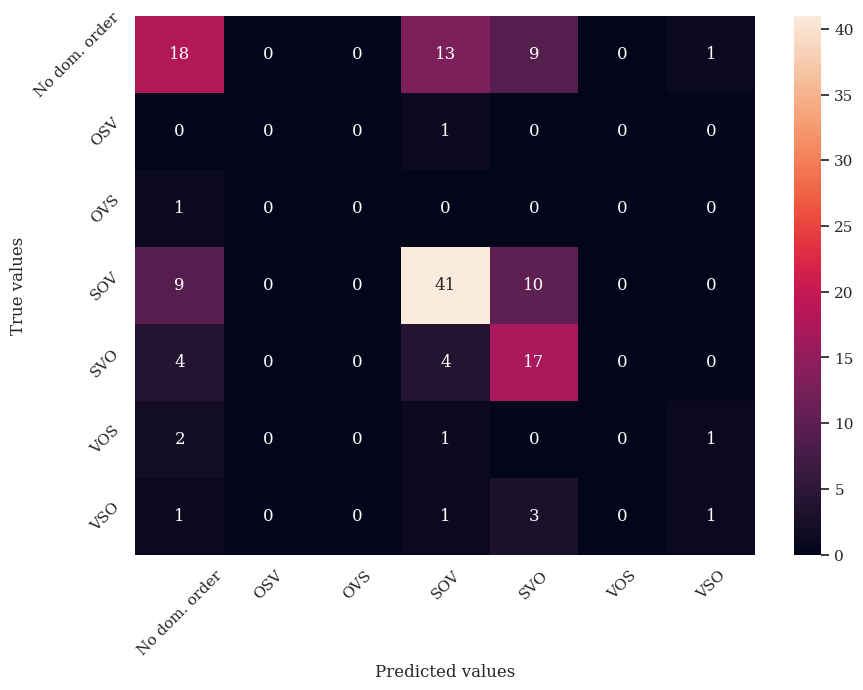

In [43]:
get_metrics('WALS 81A', '/content/drive/MyDrive/RAG Results/WALS 81A/Baseline/results.csv', baseline=True)

### Without reranker, default

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/WALS 81A/Wikipedia 50/'
out_path = '/content/drive/MyDrive/RAG Results/WALS 81A/Wikipedia 50/Default/results.csv'

rag_on_dataset(get_word_order_prompt, path_to_paragraphs, df_ground_truth, out_path, wiki=True, wals_or_grambank=False)

Matthews Correlation Coefficient: 0.5818155542036926


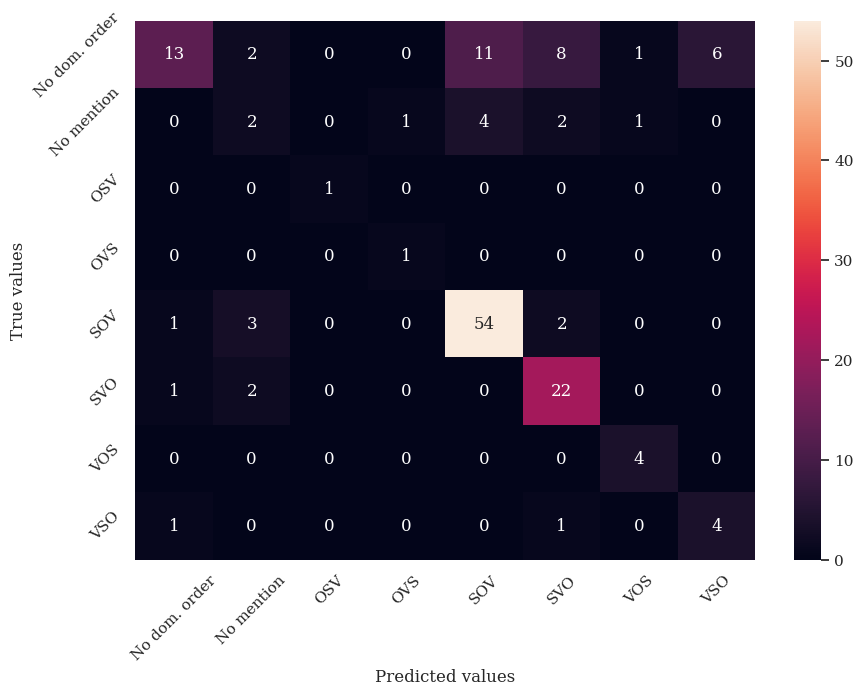

In [44]:
get_metrics('WALS 81A', '/content/drive/MyDrive/RAG Results/WALS 81A/Wikipedia 50/Default/results.csv')

### Without reranker, with WALS

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/WALS 81A/Wikipedia 50/'
out_path = '/content/drive/MyDrive/RAG Results/WALS 81A/Wikipedia 50/With Guidelines/results.csv'

rag_on_dataset(get_word_order_prompt, path_to_paragraphs, df_ground_truth, out_path, wiki=True, wals_or_grambank=True)

Matthews Correlation Coefficient: 0.5819633521077306


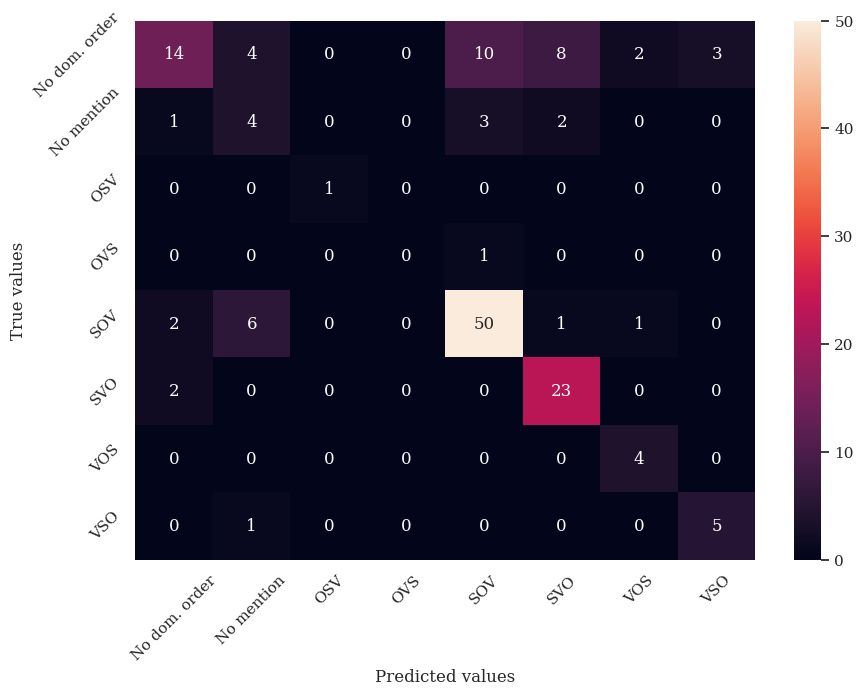

In [45]:
get_metrics('WALS 81A', '/content/drive/MyDrive/RAG Results/WALS 81A/Wikipedia 50/With Guidelines/results.csv')

### With reranker, default

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/WALS 81A/Mistral 20/'
out_path = '/content/drive/MyDrive/RAG Results/WALS 81A/Mistral 20/Default/results.csv'

rag_on_dataset(get_word_order_prompt, path_to_paragraphs, df_ground_truth, out_path, wiki=True, wals_or_grambank=False)

Matthews Correlation Coefficient: 0.613108363371514


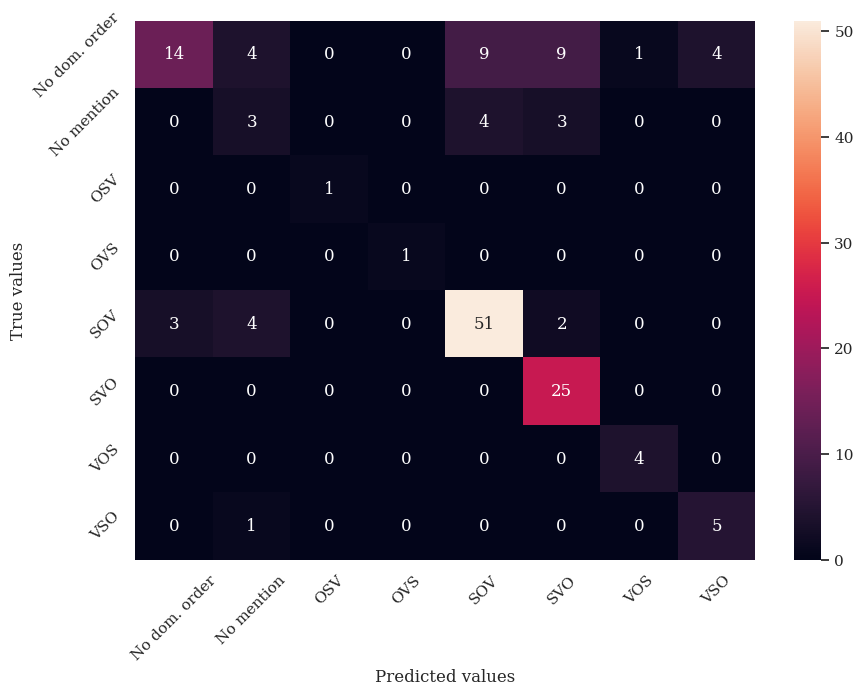

In [46]:
get_metrics('WALS 81A', '/content/drive/MyDrive/RAG Results/WALS 81A/Mistral 20/Default/results.csv')

### With reranker, with WALS

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/WALS 81A/Mistral 20/'
out_path = '/content/drive/MyDrive/RAG Results/WALS 81A/Mistral 20/With Guidelines/results.csv'

rag_on_dataset(get_word_order_prompt, path_to_paragraphs, df_ground_truth, out_path, wiki=True, wals_or_grambank=True)

Matthews Correlation Coefficient: 0.6527543115757597


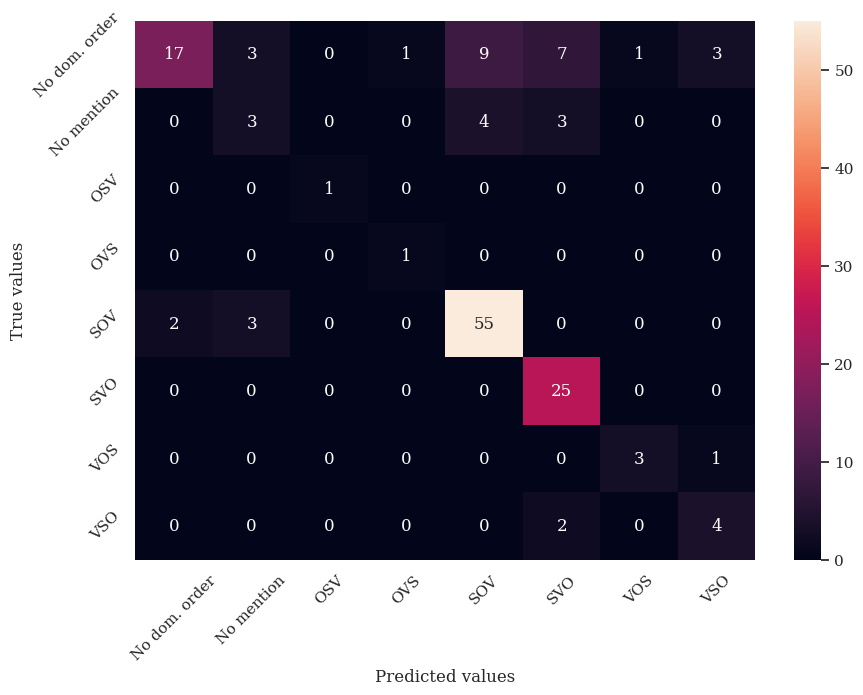

In [47]:
get_metrics('WALS 81A', '/content/drive/MyDrive/RAG Results/WALS 81A/Mistral 20/With Guidelines/results.csv')

## GB 107: Can standard negation be marked by an affix, clitic or modification of the verb?

### Baseline

In [ ]:
out_path = '/content/drive/MyDrive/RAG Results/GB 107/Baseline/results.csv'

base_prompt_on_dataset(get_negation_base_prompt, df_ground_truth, out_path)

Matthews Correlation Coefficient: 0.17910052649131297


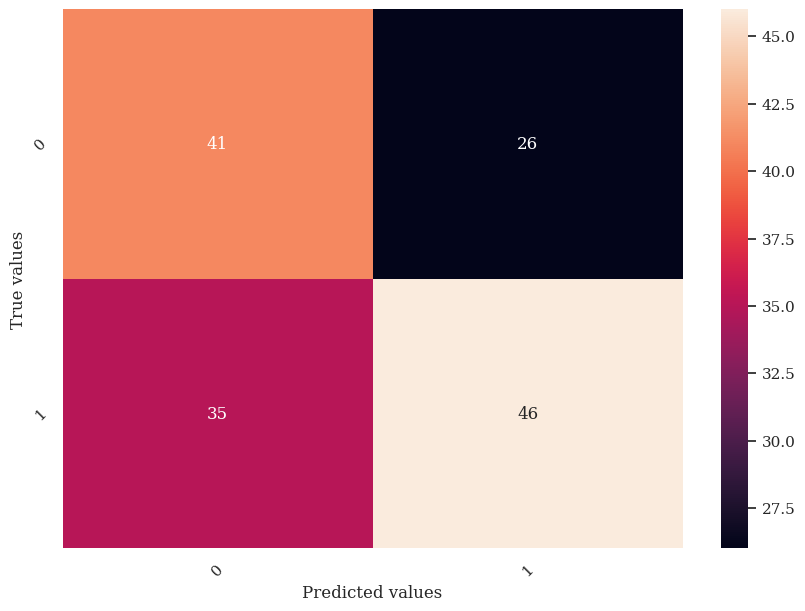

In [48]:
get_metrics('GB 107', '/content/drive/MyDrive/RAG Results/GB 107/Baseline/results.csv')

### Without reranker, default

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/GB 107/Wikipedia 50/'
out_path = '/content/drive/MyDrive/RAG Results/GB 107/Wikipedia 50/Default/results.csv'

rag_on_dataset(get_negation_prompt, path_to_paragraphs, df_ground_truth, out_path, wiki=True, wals_or_grambank=False)

Matthews Correlation Coefficient: 0.3408156760501702


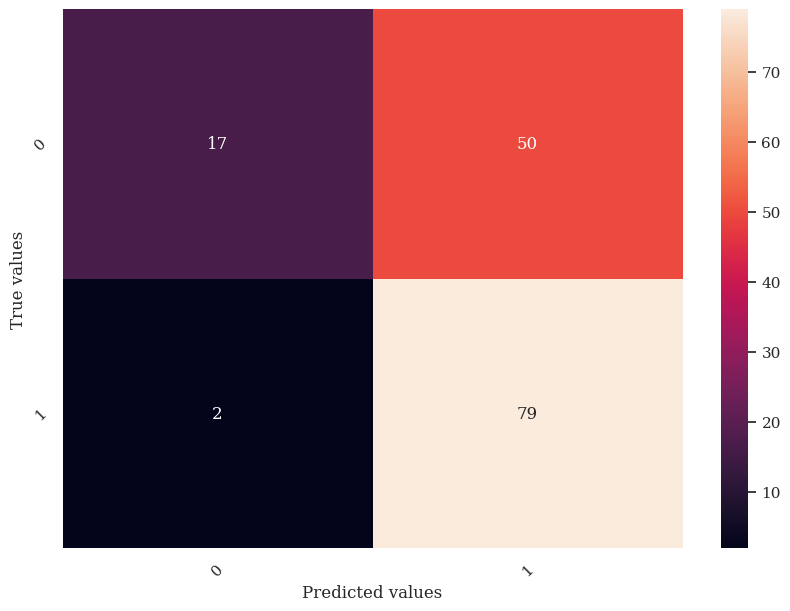

In [49]:
get_metrics('GB 107', '/content/drive/MyDrive/RAG Results/GB 107/Wikipedia 50/Default/results.csv')

### Without reranker, with Grambank

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/GB 107/Wikipedia 50/'
out_path = '/content/drive/MyDrive/RAG Results/GB 107/Wikipedia 50/With Guidelines/results.csv'

rag_on_dataset(get_negation_prompt, path_to_paragraphs, df_ground_truth, out_path, wiki=True, wals_or_grambank=True)

Matthews Correlation Coefficient: 0.45944251005174075


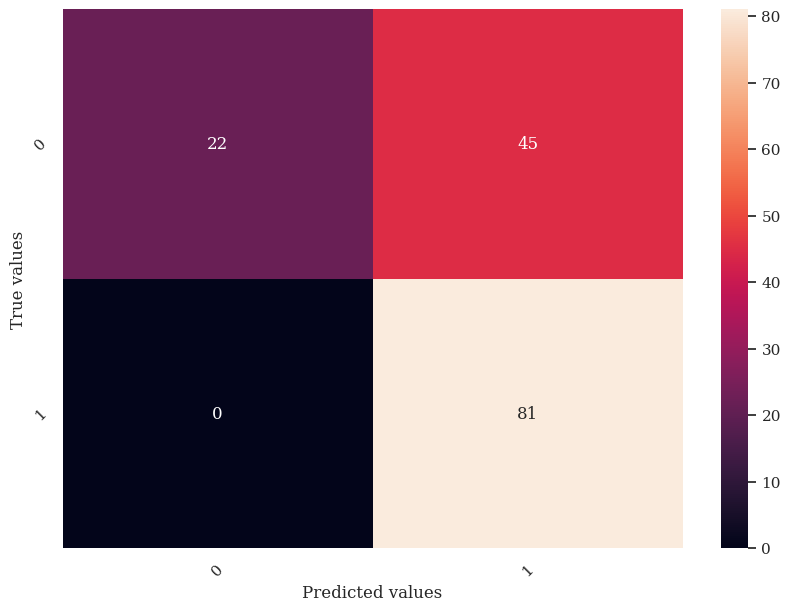

In [50]:
get_metrics('GB 107', '/content/drive/MyDrive/RAG Results/GB 107/Wikipedia 50/With Guidelines/results.csv')

### With reranker, default

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/GB 107/Mistral 20/'
out_path = '/content/drive/MyDrive/RAG Results/GB 107/Mistral 20/Default/results.csv'

rag_on_dataset(get_negation_prompt, path_to_paragraphs, df_ground_truth, out_path, wiki=True, wals_or_grambank=False)

Matthews Correlation Coefficient: 0.508589807218958


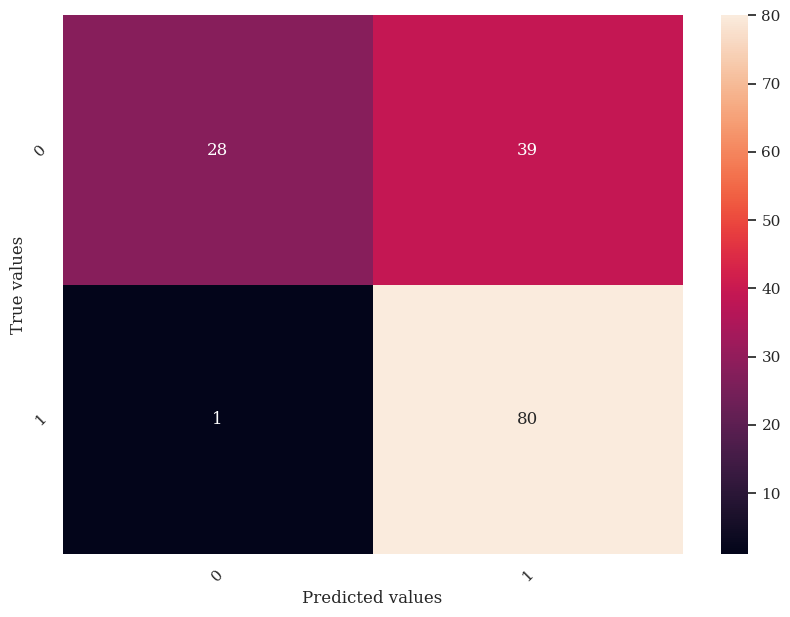

In [51]:
get_metrics('GB 107', '/content/drive/MyDrive/RAG Results/GB 107/Mistral 20/Default/results.csv')

### With reranker, with Grambank

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/GB 107/Mistral 20/'
out_path = '/content/drive/MyDrive/RAG Results/GB 107/Mistral 20/With Guidelines/results.csv'

rag_on_dataset(get_negation_prompt, path_to_paragraphs, df_ground_truth, out_path, wiki=True, wals_or_grambank=True)

Matthews Correlation Coefficient: 0.5115498824007545


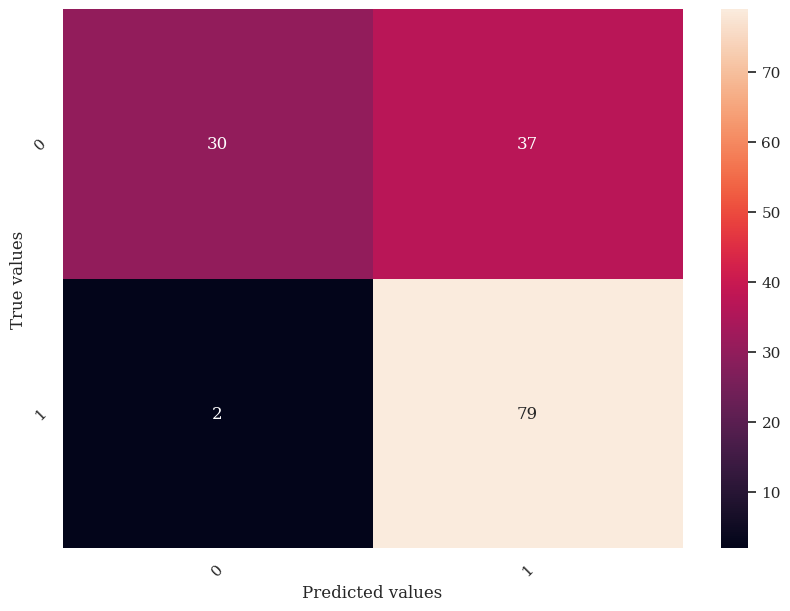

In [52]:
get_metrics('GB 107', '/content/drive/MyDrive/RAG Results/GB 107/Mistral 20/With Guidelines/results.csv')

## WALS 116A: Polar Questions

### Baseline

In [ ]:
out_path = '/content/drive/MyDrive/RAG Results/WALS 116A/Baseline/results.csv'

base_prompt_on_dataset(get_polar_questions_base_prompt, df_ground_truth, out_path)

In [55]:
get_metrics('WALS 116A', '/content/drive/MyDrive/RAG Results/WALS 116A/Baseline/results.csv')

interrogative intonation only
Matthews Correlation Coefficient: -0.08553615819557292
interrogative word order
Matthews Correlation Coefficient: 0.4948716593053935
clause-initial question particle
Matthews Correlation Coefficient: 0.03123594869779885
clause-final question particle
Matthews Correlation Coefficient: 0.04019391523477189
clause-medial question particle
Matthews Correlation Coefficient: 0.05549354380493007
interrogative verb morphology
Matthews Correlation Coefficient: -0.0435515028854656
tone
Matthews Correlation Coefficient: 0.27266392698977315


### Without reranker, default

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/WALS 116A/Wikipedia 50/'
out_path = '/content/drive/MyDrive/RAG Results/WALS 116A/Wikipedia 50/Default/results.csv'

rag_on_dataset(get_polar_questions_prompt, path_to_paragraphs, df_ground_truth, out_path, wiki=True, wals_or_grambank=False)

  0%|          | 0/148 [00:00<?, ?it/s]

In [56]:
get_metrics('WALS 116A', '/content/drive/MyDrive/RAG Results/WALS 116A/Wikipedia 50/Default/results.csv')

interrogative intonation only
Matthews Correlation Coefficient: 0.7157374901689489
interrogative word order
Matthews Correlation Coefficient: 0.7480132415430957
clause-initial question particle
Matthews Correlation Coefficient: 0.6975463751960149
clause-final question particle
Matthews Correlation Coefficient: 0.47793353175777925
clause-medial question particle
Matthews Correlation Coefficient: 0.4893444539176323
interrogative verb morphology
Matthews Correlation Coefficient: 0.3280570450235239
tone
Matthews Correlation Coefficient: 0.4198091590793945


### Without reranker, with WALS

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/WALS 116A/Wikipedia 50/'
out_path = '/content/drive/MyDrive/RAG Results/WALS 116A/Wikipedia 50/With Guidelines/results.csv'

rag_on_dataset(get_polar_questions_prompt, path_to_paragraphs, df_ground_truth, out_path, wiki=True, wals_or_grambank=True)

In [57]:
get_metrics('WALS 116A', '/content/drive/MyDrive/RAG Results/WALS 116A/Wikipedia 50/With Guidelines/results.csv')

interrogative intonation only
Matthews Correlation Coefficient: 0.7094399602838038
interrogative word order
Matthews Correlation Coefficient: 0.7480132415430957
clause-initial question particle
Matthews Correlation Coefficient: 0.4832671159029285
clause-final question particle
Matthews Correlation Coefficient: 0.43554614173488077
clause-medial question particle
Matthews Correlation Coefficient: 0.4589296879983028
interrogative verb morphology
Matthews Correlation Coefficient: 0.3580574370197165
tone
Matthews Correlation Coefficient: 0.6624096659523689


### With reranker, default

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/WALS 116A/Mistral 20/'
out_path = '/content/drive/MyDrive/RAG Results/WALS 116A/Mistral 20/Default/results.csv'

rag_on_dataset(get_polar_questions_prompt, path_to_paragraphs, df_ground_truth, out_path, wiki=True, wals_or_grambank=False)

In [58]:
get_metrics('WALS 116A', '/content/drive/MyDrive/RAG Results/WALS 116A/Mistral 20/Default/results.csv')

interrogative intonation only
Matthews Correlation Coefficient: 0.7438503215237803
interrogative word order
Matthews Correlation Coefficient: 0.7430555555555556
clause-initial question particle
Matthews Correlation Coefficient: 0.6773110001355163
clause-final question particle
Matthews Correlation Coefficient: 0.5031265535524333
clause-medial question particle
Matthews Correlation Coefficient: 0.45894277223793795
interrogative verb morphology
Matthews Correlation Coefficient: 0.3964839537996188
tone
Matthews Correlation Coefficient: 0.5200216680209274


### With reranker, with WALS

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/WALS 116A/Mistral 20/'
out_path = '/content/drive/MyDrive/RAG Results/WALS 116A/Mistral 20/With Guidelines/results.csv'

rag_on_dataset(get_polar_questions_prompt, path_to_paragraphs, df_ground_truth, out_path, wiki=True, wals_or_grambank=True)

In [59]:
get_metrics('WALS 116A', '/content/drive/MyDrive/RAG Results/WALS 116A/Mistral 20/With Guidelines/results.csv')

interrogative intonation only
Matthews Correlation Coefficient: 0.7331231369104985
interrogative word order
Matthews Correlation Coefficient: 0.5517260788686663
clause-initial question particle
Matthews Correlation Coefficient: 0.5738434975619823
clause-final question particle
Matthews Correlation Coefficient: 0.5124072255704479
clause-medial question particle
Matthews Correlation Coefficient: 0.4516868799540542
interrogative verb morphology
Matthews Correlation Coefficient: 0.36187396274812184
tone
Matthews Correlation Coefficient: 0.6920066758613097


## WALS 49A: Number of Cases

### Baseline

In [ ]:
out_path = '/content/drive/MyDrive/RAG Results/WALS 49A/Baseline/results.csv'

base_prompt_on_dataset(get_number_of_cases_base_prompt, df_ground_truth_number_of_cases, out_path)

Matthews Correlation Coefficient: 0.23081161974890824


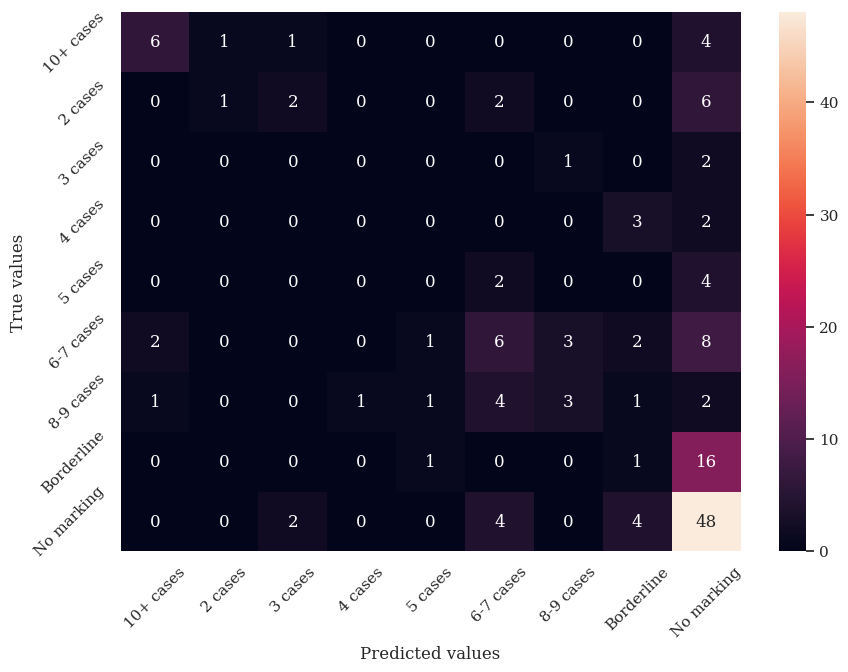

In [60]:
get_metrics('WALS 49A', '/content/drive/MyDrive/RAG Results/WALS 49A/Baseline/results.csv')

### Without reranker, default

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/WALS 49A/Wikipedia 50/'
out_path = '/content/drive/MyDrive/RAG Results/WALS 49A/Wikipedia 50/Default/results.csv'

rag_on_dataset(get_number_of_cases_prompt, path_to_paragraphs, df_ground_truth_number_of_cases, out_path, wiki=True, wals_or_grambank=False)

Matthews Correlation Coefficient: 0.3338109458453243


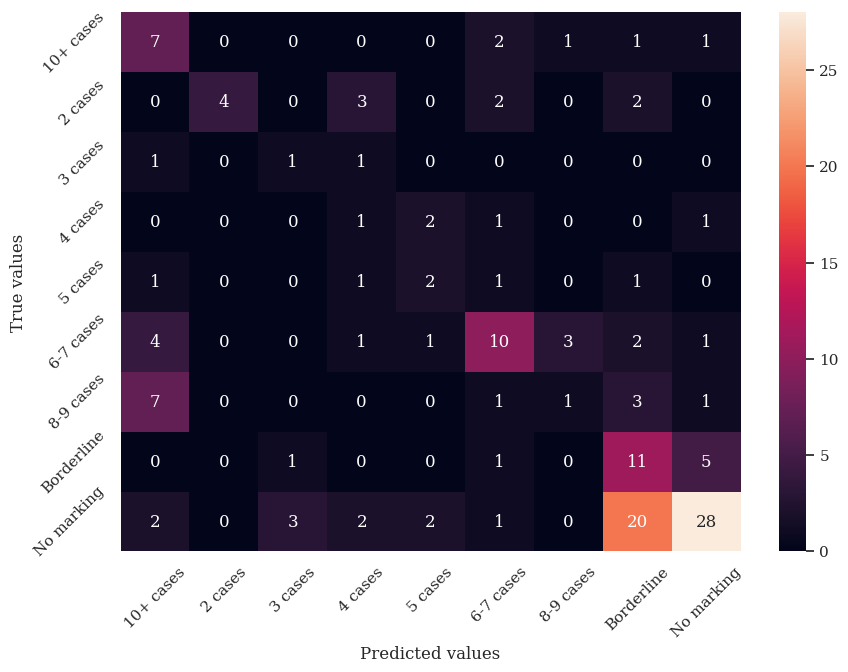

In [61]:
get_metrics('WALS 49A', '/content/drive/MyDrive/RAG Results/WALS 49A/Wikipedia 50/Default/results.csv')

### Without reranker, with WALS

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/WALS 49A/Wikipedia 50/'
out_path = '/content/drive/MyDrive/RAG Results/WALS 49A/Wikipedia 50/With Guidelines/results.csv'

rag_on_dataset(get_number_of_cases_prompt, path_to_paragraphs, df_ground_truth_number_of_cases, out_path, wiki=True, wals_or_grambank=True)

Matthews Correlation Coefficient: 0.3862024986397506


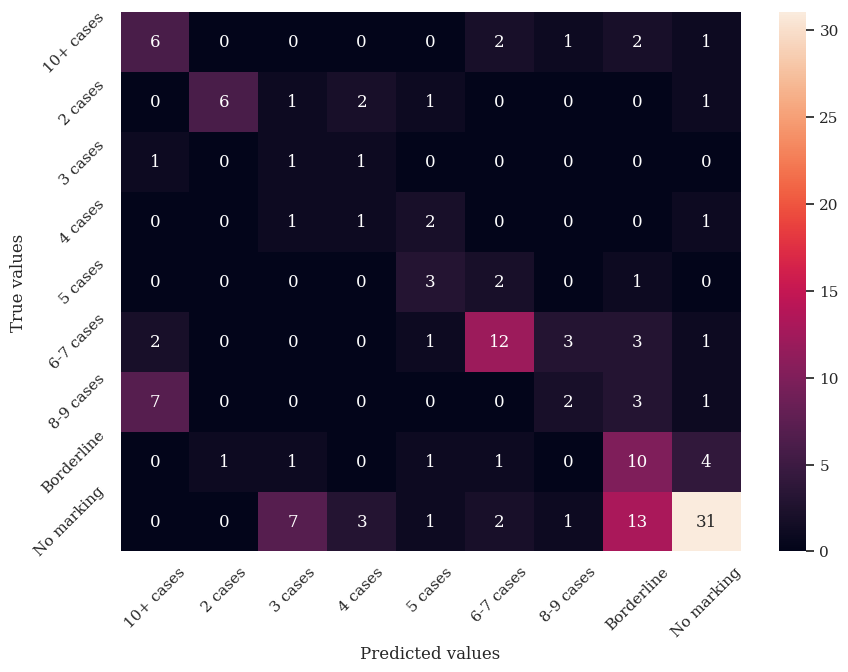

In [62]:
get_metrics('WALS 49A', '/content/drive/MyDrive/RAG Results/WALS 49A/Wikipedia 50/With Guidelines/results.csv')

### With reranker, default

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/WALS 49A/Mistral 20/'
out_path = '/content/drive/MyDrive/RAG Results/WALS 49A/Mistral 20/Default/results.csv'

rag_on_dataset(get_number_of_cases_prompt, path_to_paragraphs, df_ground_truth_number_of_cases, out_path, wiki=True, wals_or_grambank=False)

Matthews Correlation Coefficient: 0.3572162474549242


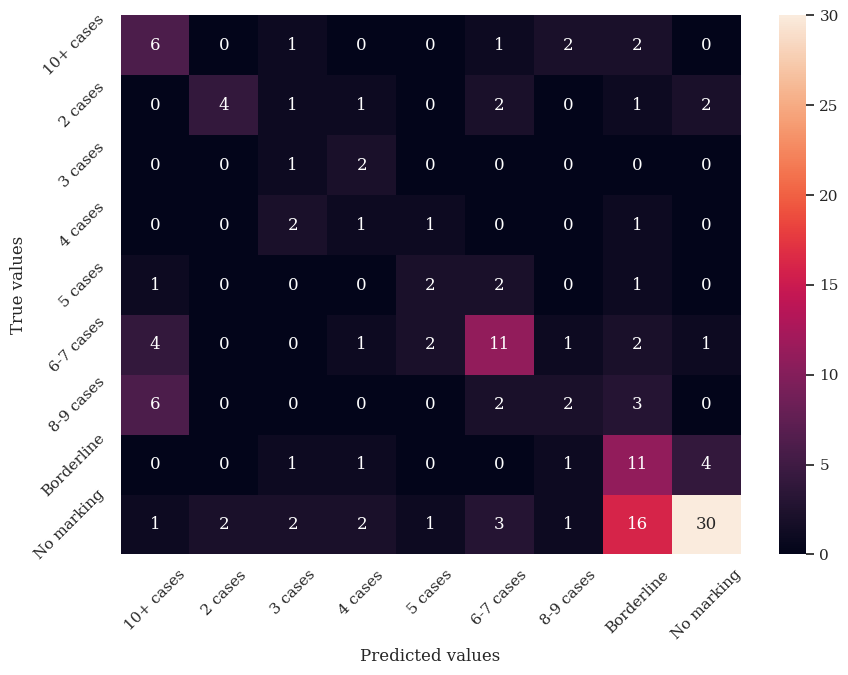

In [63]:
get_metrics('WALS 49A', '/content/drive/MyDrive/RAG Results/WALS 49A/Mistral 20/Default/results.csv')

### With reranker, with WALS

In [ ]:
path_to_paragraphs = '/content/drive/MyDrive/Grammars Paragraphs/WALS 49A/Mistral 20/'
out_path = '/content/drive/MyDrive/RAG Results/WALS 49A/Mistral 20/With Guidelines/results.csv'

rag_on_dataset(get_number_of_cases_prompt, path_to_paragraphs, df_ground_truth_number_of_cases, out_path, wiki=True, wals_or_grambank=True)

Matthews Correlation Coefficient: 0.4143663903430608


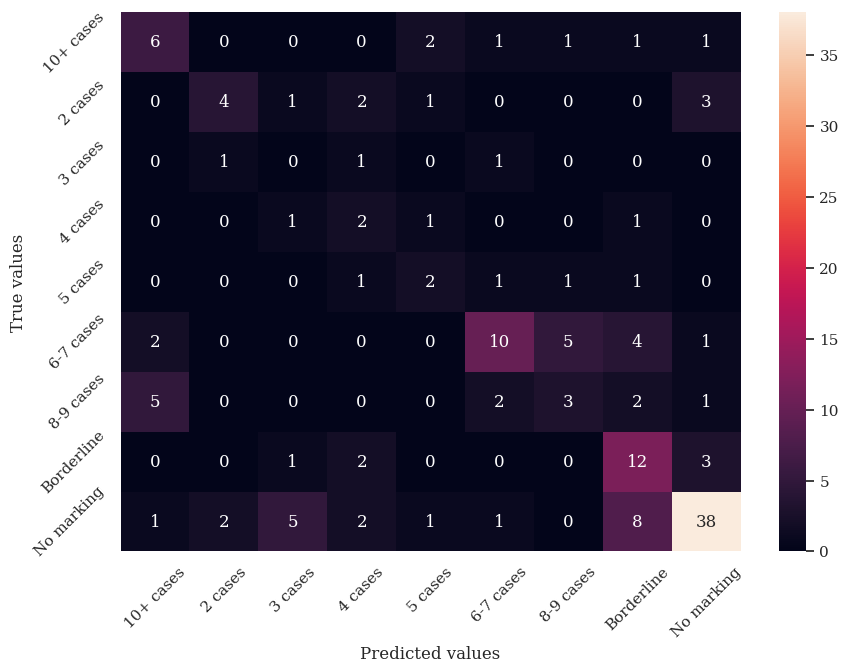

In [64]:
get_metrics('WALS 49A', '/content/drive/MyDrive/RAG Results/WALS 49A/Mistral 20/With Guidelines/results.csv')